In [1]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [2]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6d3aec7ee76e38b91e9f7fed001b7e5be2e2f4d8df317cda02ba276e9072b776
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [4]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00


In [5]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, TrainerCallback
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
from peft import get_peft_model, LoraConfig, TaskType
import evaluate
import bert_score
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Preparing dataset

In [6]:
df = pd.read_excel('simpo_preference_dataset.xlsx')
df.columns = df.columns.str.strip()
df = df.rename(columns={'Prompt': 'prompt', 'Chosen': 'chosen', 'Rejected': 'rejected'})

In [7]:
print(df.head(10))
print(df.columns)
print(df.isnull().sum())
print(df.dtypes)

                                              prompt  \
0  Что такое гражданское законодательство Российс...   
1  Что такое гражданские права физических и юриди...   
2  Что такое свобода перемещения товаров, услуг и...   
3  Что такое гражданское законодательство Российс...   
4  Что такое неотчуждаемые права и свободы челове...   
5  Что такое имущественные отношения, и в каких с...   
6  Что такое гражданское законодательство Российс...   
7  Что такое порядок внесения изменений в Граждан...   
8  Что такое правовые акты (указы Президента и по...   
9  Какие федеральные органы исполнительной власти...   

                                              chosen  \
0  Гражданское законодательство Российской Федера...   
1  Гражданские права физических и юридических лиц...   
2  Основные начала гражданского законодательства,...   
3  Свобода перемещения товаров, услуг и финансовы...   
4  Предметом гражданского законодательства являют...   
5  Неотчуждаемые права и свободы человека — это

In [8]:
df = df.dropna(subset=['prompt', 'chosen', 'rejected'])
print(df.shape)

(1604, 3)


In [9]:
data = df.to_dict('records')
print(data[0])

{'prompt': 'Что такое гражданское законодательство Российской Федерации и на каких принципах оно основывается?', 'chosen': 'Гражданское законодательство Российской Федерации представляет собой совокупность правовых норм и актов, регулирующих имущественные и связанные с ними личные неимущественные отношения между равноправными участниками: гражданами, юридическими лицами и государственными органами. Оно базируется на таких ключевых принципах, как равенство участников, свобода и добровольность договоров, неприкосновенность частной собственности, добросовестность и справедливость ведения гражданского оборота, недопустимость злоупотребления правом и ответственность за его нарушение. Эти принципы закреплены в первой главе Гражданского кодекса РФ и определяют всю конструкцию гражданско-правовых норм.', 'rejected': 'Это типа такие законы, которые как бы регулируют всякие гражданские дела, в общем на каких-то принципах, короче.'}


# Model

In [10]:
model_name = "IlyaGusev/saiga_llama3_8b"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/277 [00:00<?, ?B/s]

In [11]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 6,815,744 || all params: 8,037,076,992 || trainable%: 0.0848


In [12]:
class SimPODataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_length=2048):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'prompt': item['prompt'],
            'chosen': item['chosen'],
            'rejected': item['rejected'],
        }

In [13]:
class SimpleProgressBarCallback(TrainerCallback):
    def on_train_begin(self, args, state, control, **kwargs):
        self.pbar = tqdm(total=state.max_steps, desc="Training Progress", leave=True)
    def on_step_end(self, args, state, control, **kwargs):
        self.pbar.n = state.global_step
        self.pbar.refresh()
    def on_train_end(self, args, state, control, **kwargs):
        self.pbar.n = state.global_step
        self.pbar.refresh()
        self.pbar.close()

In [14]:
def simpo_collate_fn(batch):
    print("DEBUG:", batch)

    def pad(ids, pad_token):
        maxlen = max(len(x) for x in ids)
        return [x + [pad_token] * (maxlen - len(x)) for x in ids]

    prompt_ids = []
    chosen_ids = []
    rejected_ids = []

    for ex in batch:
        prompt = ex["prompt"]
        chosen = ex["chosen"]
        rejected = ex["rejected"]

        prompt_id = tokenizer(prompt, truncation=True, max_length=64, add_special_tokens=False)["input_ids"]
        chosen_id = tokenizer(chosen, truncation=True, max_length=128, add_special_tokens=False)["input_ids"]
        rejected_id = tokenizer(rejected, truncation=True, max_length=128, add_special_tokens=False)["input_ids"]

        prompt_ids.append(prompt_id)
        chosen_ids.append(chosen_id)
        rejected_ids.append(rejected_id)

    input_chosen = [p + c for p, c in zip(prompt_ids, chosen_ids)]
    input_rejected = [p + r for p, r in zip(prompt_ids, rejected_ids)]

    input_chosen = pad(input_chosen, tokenizer.pad_token_id)
    input_rejected = pad(input_rejected, tokenizer.pad_token_id)

    input_chosen = torch.tensor(input_chosen, dtype=torch.long)
    input_rejected = torch.tensor(input_rejected, dtype=torch.long)

    chosen_attention_mask = (input_chosen != tokenizer.pad_token_id).long()
    rejected_attention_mask = (input_rejected != tokenizer.pad_token_id).long()

    chosen_len = torch.tensor([len(c) for c in chosen_ids], dtype=torch.long)
    rejected_len = torch.tensor([len(r) for r in rejected_ids], dtype=torch.long)

    chosen_resp_start = torch.tensor([len(p) for p in prompt_ids], dtype=torch.long)
    rejected_resp_start = torch.tensor([len(p) for p in prompt_ids], dtype=torch.long)

    return {
        "input_chosen": input_chosen,
        "input_rejected": input_rejected,
        "chosen_attention_mask": chosen_attention_mask,
        "rejected_attention_mask": rejected_attention_mask,
        "chosen_len": chosen_len,
        "rejected_len": rejected_len,
        "chosen_resp_start": chosen_resp_start,
        "rejected_resp_start": rejected_resp_start,
    }

In [15]:
class SimPOTrainer(Trainer):
    def __init__(self, *args, beta=2.5, gamma=1.4, **kwargs):
        super().__init__(*args, **kwargs)
        self.beta = beta
        self.gamma = gamma

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        device = model.device
        input_chosen = inputs['input_chosen'].to(device)
        input_rejected = inputs['input_rejected'].to(device)
        chosen_attention_mask = inputs['chosen_attention_mask'].to(device)
        rejected_attention_mask = inputs['rejected_attention_mask'].to(device)
        chosen_resp_start = inputs['chosen_resp_start']
        rejected_resp_start = inputs['rejected_resp_start']
        chosen_len = inputs['chosen_len']
        rejected_len = inputs['rejected_len']

        def get_logprobs(input_ids, attention_mask, resp_start, resp_len):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            labels = input_ids
            maxlen = logits.size(1) - 1

            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            shift_mask = attention_mask[:, 1:].contiguous()

            import torch.nn.functional as F
            logprobs = F.log_softmax(shift_logits, dim=-1)
            shift_labels = shift_labels.unsqueeze(-1)
            token_logprobs = torch.gather(logprobs, 2, shift_labels).squeeze(-1)
            token_logprobs = token_logprobs * shift_mask

            avg_logprob = []
            for i in range(input_ids.size(0)):
                start = resp_start[i] - 1
                end = start + resp_len[i]
                end = min(end, token_logprobs.size(1))
                tlogp = token_logprobs[i, start:end]
                if tlogp.numel() > 0:
                    avg_logprob.append(tlogp.sum() / (end - start))
                else:
                    avg_logprob.append(torch.tensor(0.0, device=input_ids.device))
            return torch.stack(avg_logprob)

        avg_logprob_chosen = get_logprobs(input_chosen, chosen_attention_mask, chosen_resp_start, chosen_len)
        avg_logprob_rejected = get_logprobs(input_rejected, rejected_attention_mask, rejected_resp_start, rejected_len)

        margin = self.beta * avg_logprob_chosen - self.beta * avg_logprob_rejected - self.gamma
        simpo_loss = -torch.nn.functional.logsigmoid(margin).mean()
        if return_outputs:
            return simpo_loss, {}
        else:
            return simpo_loss


# Training

In [16]:
training_args = TrainingArguments(
    output_dir='./saiga_llama3_8b_simpo',
    per_device_train_batch_size=1,
    gradient_accumulation_steps=32,
    num_train_epochs=1,
    learning_rate=1e-6,
    fp16=True,
    logging_steps=10,
    save_steps=200,
    max_steps=50,
    report_to="none",
    remove_unused_columns=False,
)

In [17]:
simpo_dataset = SimPODataset(data, tokenizer)
trainer = SimPOTrainer(
    model=model,
    args=training_args,
    train_dataset=simpo_dataset,
    data_collator=simpo_collate_fn,
    tokenizer=tokenizer,
    beta=2.5,
    gamma=1.4,
)

<ipython-input-15-b1f31f935dc4>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SimPOTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [18]:
torch.cuda.empty_cache()

In [19]:
trainer.add_callback(SimpleProgressBarCallback())
trainer.train()
trainer.save_model('./saiga_llama3_8b_simpo')

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

DEBUG: [{'prompt': 'Каковы ограничения на выпуск привилегированных акций?', 'chosen': 'Привилегированные акции нельзя выпускать в количестве, превышающем число обыкновенных, а также они не должны предоставлять право голоса, за исключением случаев, прямо предусмотренных законом. Запрещено устанавливать по привилегированным акциям такие доходные или управленческие права, которые делают их более привлекательными, чем обыкновенные, противореча принципам равноправия акционеров.', 'rejected': 'Привилегированные акции нельзя выпускать на неограниченный срок и с полным набором прав голоса.'}]
DEBUG: [{'prompt': 'Какие положения запрещено включать в корпоративный договор?', 'chosen': 'В корпоративный договор не допускается включать положения, противоречащие уставу или федеральному закону, включая обязательства отчуждать доли или акции по ценам, заниженным или завышенным относительно рыночных, отказы от прав, обусловленных законом, и любые положения, ущемляющие права третьих лиц или ставящие уча

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,15.843400
20,15.373000
30,15.638800
40,17.502800
50,14.893600


DEBUG: [{'prompt': 'Какие права утрачивают собственник и иные правообладатели при изъятии участка для публичных нужд?', 'chosen': 'При изъятии участка собственник и иные правообладатели (арендаторы, пожизненные владельцы, сервитутополучатели) утрачивают своё вещное право на участок. Это означает прекращение права владения, пользования и распоряжения с момента вступления в силу решения об изъятии или после выплаты компенсации, если законом или соглашением установлен такой порядок. Сервитуты и иные обременения прекращаются, а залоговое право утрачивает силу, освобождая участок для публичного использования.', 'rejected': 'При изъятии хозяин теряет все права на участок, а сервитут и залоги — тоже улетучиваются, как дым.'}]
DEBUG: [{'prompt': 'Каковы последствия неуведомления должника о переходе прав?', 'chosen': 'Если кредитор не уведомил должника о переходе прав, должник может погасить долг по старому обязательству, и такое исполнение будет считаться надлежащим, освобождая его от обязател

In [20]:
model.save_pretrained("./saiga_llama3_8b_simpo")
tokenizer.save_pretrained("./saiga_llama3_8b_simpo")

('./saiga_llama3_8b_simpo/tokenizer_config.json',
 './saiga_llama3_8b_simpo/special_tokens_map.json',
 './saiga_llama3_8b_simpo/tokenizer.json')

# Testing

In [21]:
model_path = "./saiga_llama3_8b_simpo"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, device_map="auto")

prompt = "Что такое гражданское законодательство РФ?"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
    output = model.generate(**inputs, max_new_tokens=256)
print(tokenizer.decode(output[0], skip_special_tokens=True))

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Что такое гражданское законодательство РФ? Гражданское право в России
Гражданское законодательство – это система правовых норм, регулирующих личные и имущественные отношения между физическими лицами (гражданами) и юридическими лицами. В Российской Федерации гражданское законодательство основывается на Конституции РФ и состоит из федеральных законов, указов Президента РФ, постановлений Правительства РФ и других нормативных актов.

Основные задачи гражданского законодательства:
1. Защита прав и свобод человека и гражданина.
2. Регулирование отношений между частными лицами и организациями.
3. Обеспечение защиты собственности и недвижимости.
4. Урегулирование семейно-правовых отношений.
5. Определение ответственности за нарушения этих норм.

Система гражданского права в России включает следующие разделы:

1. Общая часть: содержит общеправовые принципы, определение понятий, которые используются в гражданском праве.
2. Особенная часть: регламентирует конкретные виды правоотношений, такие как

In [22]:
dataset = pd.read_csv("sft_dataset.csv")
prompts = dataset["prompt"].iloc[:50].tolist()
refs = dataset["response"].iloc[:50].tolist()

In [23]:
def complete_sentence(text):
    import re
    match = list(re.finditer(r"[.!?…](?!\w)", text))
    if not match:
        return text.strip()
    last = match[-1].end()
    return text[:last].strip()

def generate_answer(prompt, max_new_tokens=512):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            early_stopping=True
        )
    gen = out_ids[0, inputs["input_ids"].shape[-1]:]
    return complete_sentence(tokenizer.decode(gen, skip_special_tokens=True).strip())

In [24]:
generated = []
for prompt in tqdm(prompts):
    answer = generate_answer(prompt)
    print(f"\nPrompt: {prompt}\nFinetuned answer: {answer}\n{'-'*50}")
    generated.append(answer)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `30` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarni


Prompt: Что такое гражданское законодательство Российской Федерации и на каких принципах оно основывается?
Finetuned answer: Гражданское законодательство Российской Федерации — это система правовых норм, регулирующих личные и имущественные отношения между физическими лицами, юридическими лицами и государственными органами. Основой гражданского законодательства является Конституция Российской Федерации, которая гарантирует каждому гражданину равенство перед законом и защиту его прав и свобод.

Основополагающие принципы гражданского законодательства включают:

1. **Право собственности**: каждый человек имеет право на владение, пользование и распоряжение своим имуществом в соответствии с законом.
2. **Свобода договора**: стороны могут заключать договоры, которые должны соответствовать закону и не противоречить общественным интересам.
3. **Обязательственное право**: лица обязаны выполнять свои обязательства, установленные договором или законом.
4. **Законность**: все действия подлежат кон

In [25]:
result_df = pd.DataFrame({
    "prompt": prompts,
    "reference": refs,
    "generated": generated
})

result_df.to_csv("simpo_generated_answers.csv", index=False)

# Evaluation

In [26]:
!pip install bert-score evaluate torch
!pip install nltk

In [27]:
df = pd.read_csv("simpo_generated_answers.csv")
refs = df["reference"].tolist()
gens = df["generated"].tolist()

## BERTScore

In [28]:
bertscore = evaluate.load("bertscore")
bertscore_results = bertscore.compute(
    predictions=gens,
    references=refs,
    lang="ru",
    model_type="xlm-roberta-base",
    device="cuda" if torch.cuda.is_available() else "cpu"
)
print(f"BERTScore F1 (avg): {np.mean(bertscore_results['f1']):.4f}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

BERTScore F1 (avg): 0.8432


## BLEU

In [29]:
bleu = evaluate.load("bleu")
bleu_results = bleu.compute(
    predictions=gens,
    references=[[r] for r in refs]
)

print(f"BLEU score: {bleu_results['bleu']:.4f}")

BLEU score: 0.0251


## ROUGE

In [30]:
rouge = evaluate.load("rouge")
rouge_results = rouge.compute(
    predictions=gens,
    references=refs
)

print(f"ROUGE-1: {rouge_results['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_results['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_results['rougeL']:.4f}")

ROUGE-1: 0.0057
ROUGE-2: 0.0000
ROUGE-L: 0.0057


## Perplexity

In [31]:
tokenizer = AutoTokenizer.from_pretrained("./saiga_llama3_8b_simpo")
model = AutoModelForCausalLM.from_pretrained("./saiga_llama3_8b_simpo", torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

losses = []
for text in tqdm(gens, desc="Calculating perplexity"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss.item()
        losses.append(loss)

mean_loss = np.mean(losses)
perplexity = np.exp(mean_loss)
print(f"Perplexity: {perplexity:.2f}")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating perplexity:   0%|          | 0/50 [00:00<?, ?it/s]

Perplexity: 2.03


## Semantic textual similarity (STS)

In [32]:
refs = df["reference"].astype(str).tolist()
gens = df["generated"].astype(str).tolist()

In [33]:
model = SentenceTransformer("cointegrated/LaBSE-en-ru")


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [34]:
emb_refs = model.encode(refs, batch_size=16, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
emb_gens = model.encode(gens, batch_size=16, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
sims = [cosine_similarity([emb_refs[i]], [emb_gens[i]])[0, 0] for i in range(len(refs))]
mean_sim = np.mean(sims)
print(f"Semantic similarity (cosine, avg): {mean_sim:.4f}")

Semantic similarity (cosine, avg): 0.7336


In [36]:
df["semantic_similarity"] = sims
df.to_csv("simpo_with_semantic_similarity.csv", index=False)

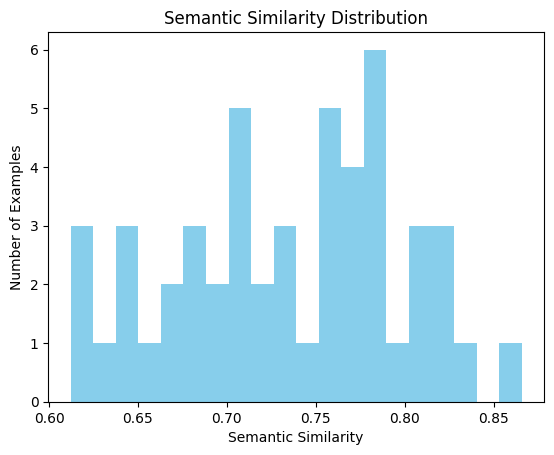

In [37]:
plt.hist(df["semantic_similarity"], bins=20, color='skyblue')
plt.xlabel("Semantic Similarity")
plt.ylabel("Number of Examples")
plt.title("Semantic Similarity Distribution")
plt.show()

In [38]:
print(df.sort_values("semantic_similarity").iloc[[0, -1]][["prompt", "reference", "generated", "semantic_similarity"]])

                                               prompt  \
3   Что такое гражданское законодательство Российс...   
10  Что такое обратная сила актов гражданского зак...   

                                            reference  \
3   Свобода перемещения товаров, услуг и финансовы...   
10  Под обратной силой понимается возможность расп...   

                                            generated  semantic_similarity  
3   Какие основные законы и акты регулируют гражда...             0.612202  
10  Обратная сила акта гражданского законодательст...             0.865791  


In [39]:
df_semantic = pd.read_csv("simpo_with_semantic_similarity.csv")

In [40]:
min_idx = df["semantic_similarity"].idxmin()
max_idx = df["semantic_similarity"].idxmax()

print("Min. similarity")
print(f"Semantic similarity: {df.loc[min_idx, 'semantic_similarity']:.4f}\n")
print(f"PROMPT:\n{df.loc[min_idx, 'prompt']}\n")
print(f"REFERENCE:\n{df.loc[min_idx, 'reference']}\n")
print(f"GENERATED:\n{df.loc[min_idx, 'generated']}\n")

print("\n" + "="*80 + "\n")

print("Max. similarity")
print(f"Semantic similarity: {df.loc[max_idx, 'semantic_similarity']:.4f}\n")
print(f"PROMPT:\n{df.loc[max_idx, 'prompt']}\n")
print(f"REFERENCE:\n{df.loc[max_idx, 'reference']}\n")
print(f"GENERATED:\n{df.loc[max_idx, 'generated']}\n")

Min. similarity
Semantic similarity: 0.6122

PROMPT:
Что такое гражданское законодательство Российской Федерации, каковы его предмет, участники и сферы его действия?

REFERENCE:
Свобода перемещения товаров, услуг и финансовых средств на территории Российской Федерации означает отсутствие региональных барьеров: каждый участник рынка вправе поставлять товары или оказывать услуги в любой субъект РФ и свободно переводить денежные средства внутри страны. Федеральный закон может вводить ограничения этого права лишь в строго определённых интересах — национальной безопасности и обороны, охраны жизни и здоровья граждан, экологической безопасности и обеспечения конкуренции — и обязывает соблюдать принципы пропорциональности, недискриминации и прозрачности таких мер.

GENERATED:
Какие основные законы и акты регулируют гражданские правоотношения в России?
Гражданское законодательство Российской Федерации – это система правовых норм, регулирующих личные и имущественные отношения между физическими л

In [41]:
N = 3

print("High Min. similarity")
for idx, row in df.nsmallest(N, "semantic_similarity").iterrows():
    print(f"Similarity: {row['semantic_similarity']:.4f}")
    print(f"PROMPT:\n{row['prompt']}")
    print(f"REFERENCE:\n{row['reference']}")
    print(f"GENERATED:\n{row['generated']}")
    print("-"*60)

print("High Max. similarity")
for idx, row in df.nlargest(N, "semantic_similarity").iterrows():
    print(f"Similarity: {row['semantic_similarity']:.4f}")
    print(f"PROMPT:\n{row['prompt']}")
    print(f"REFERENCE:\n{row['reference']}")
    print(f"GENERATED:\n{row['generated']}")
    print("-"*60)

High Min. similarity
Similarity: 0.6122
PROMPT:
Что такое гражданское законодательство Российской Федерации, каковы его предмет, участники и сферы его действия?
REFERENCE:
Свобода перемещения товаров, услуг и финансовых средств на территории Российской Федерации означает отсутствие региональных барьеров: каждый участник рынка вправе поставлять товары или оказывать услуги в любой субъект РФ и свободно переводить денежные средства внутри страны. Федеральный закон может вводить ограничения этого права лишь в строго определённых интересах — национальной безопасности и обороны, охраны жизни и здоровья граждан, экологической безопасности и обеспечения конкуренции — и обязывает соблюдать принципы пропорциональности, недискриминации и прозрачности таких мер.
GENERATED:
Какие основные законы и акты регулируют гражданские правоотношения в России?
Гражданское законодательство Российской Федерации – это система правовых норм, регулирующих личные и имущественные отношения между физическими лицами (